<a href="https://colab.research.google.com/github/SKJNR/Face-Counting-/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis

In [1]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data_dir = Path('.')

## Coaching Program

### Summary
* This mainly comprised of preparing the dataset and a few visualizations.
* The visualization can easily be edited to suite queries.
* The candidates of interest (Those who filled the survey in all 4 semesters) are classified as main_df.
* Natural Language Processing or information extraction (e.g Named-entity recognition) would be applied on the following columns:
    * What was it about this speaker that made him/her/them your favorite
    * Do you have any artists that you would like to recommend as possible speakers for future TMC events at Longy?
    * In one or two sentences, would you be willing to summarize the impact that The Career Coaching Program has had on your musical training and overall development?
    * Do you have any recommendations for artists (or types of artists) that we should invite as TMC Speakers in the future?
* **Are ALL the options 'Strongly Disagree', 'Disagree', 'Maybe'/'Neutral', 'Agree', 'Strongly Agree' included in all the survey??!!!**
* The agreement columns might be reduced to 3 depending on further analysis.
* With more dataset, I could do some wrangling, and make credible assumptions.

### Abbreviations
* F19: Fall 2019
* S20: Spring 2020
* F20: Fall 2020
* S21: Spring 2021

### Read Datasets

In [3]:
semester1 = pd.read_excel(data_dir/'Coaching Program Impact Assessment_ Fall Semester 2019(1-85).xlsx')
semester2 = pd.read_excel(data_dir/'Coaching Program Impact Assessment_ Spring 2020(1-35) (3).xlsx')
semester3 = pd.read_excel(data_dir/'Coaching Program Impact Assessment_ Fall Semester 2020(1-73) (1).xlsx')
semester4 = pd.read_excel(data_dir/'Coaching Program Impact Assessment_ Spring 2021(1-48).xlsx')

In [4]:
semester1['Semester'] = 'F19'
semester2['Semester'] = 'S20'
semester3['Semester'] = 'F20'
semester4['Semester'] = 'S21'

In [5]:
semesters = [semester1, semester2, semester3, semester4]

In [6]:
for x in semesters:
    print(x.Semester[0], x.shape)

F19 (85, 28)
S20 (35, 29)
F20 (73, 28)
S21 (48, 34)


### Combine and clean datasets

In [7]:
df = pd.concat([semester1, semester2, semester3, semester4], ignore_index=True)
df.shape

(241, 44)

In [8]:
# Classifying columns for preparation, delete and analysis
cols_to_drop = ['ID']
date_cols = ['Start time', 'Completion time'] #.dt.
student_cols = ['Name', 'Email']
custom_cols = ['Semester']
nlp_cols = [
    'What was it about this speaker that made him/her/them your favorite', #all
    'In one or two sentences, would you be willing to summarize the impact that The Career Coaching Program has had on your musical training and overall development?', #f20,s21
    #'Do you have any artists that you would like to recommend as possible speakers for future TMC events at Longy?', #f20, s21
    #'Do you have any recommendations for artists (or types of artists) that we should invite as TMC Speakers in the future?', #s20
    'Recommeded Speakers'
]
cat_cols = {
    'agree': [
        'Through coaching, I discovered connections between my values and my music.', # all
        'Coaching helped me identify my goals.', # all
        'Coaching helped me determine next steps toward reaching my goals.', # except s20
        #'I created next steps towards reaching my goals.', #s20
        'Coaching sessions helped me decide what classes to take at Longy.', #all
        'Clarity for decision making', #all
        'Accountability for my goals', #all
        'Increased self-motivation', #all
        'Awareness of my values', #all
        'Support for personal growth', #all
        'I would recommend individual coaching to current or prospective students.', #all
        'The Multifaceted Career (TMC) Speaker Series helped me think about my own life and career options in a broader way.', #all
        'I would recommend The Multifaceted Career (TMC) Series to current or perspective students.', #all
        'Coaching was as effective on zoom as it was in person.', #s20
        'I will use the individual career coaching services at Longy after I graduate.', #s20
        'I am aware of the coaching program requirements for graduation.', #s20
        'The Coaching Foundations Course (group coaching) laid an important foundation for the discussions in my individual coaching sessions.', #s20
        'The Artist Statement workshop helped me begin to align my career aspirations with my values.', #s21
        'The Coaching Foundations Course (5 sessions at the beginning of grad school) provided a framework for understanding myself and how coaching worked at Longy.', #s21
        'The Multifaceted Career Speaker Series helped me thinking more expansively about my own career possibilities.', #s21
        'Individual coaching provided a space to reflect on who I was becoming and what I wanted to do after Longy.', #s21
        'I plan to use the career coaching services after I graduate.', #s21
        
    ],
    'others': [
        'Language',
        'When did you begin pursuing your degree at Longy?', # Semester (f20,s21)
        'Which department are you in?', # Department (f20,s21)
        'What degree are you currently pursuing?', # Degree (f20,s21)
        'I have received career coaching sessions at Longy', #Yes/No (f20,s21)
        'My favorite TMC Speaker was...', # (f19,f20)
        #'My favorite TMC Speaker this semester was...', #s20
        #'My favorite TMC Speaker from the Spring 2021 Series was...', #s21
        'Have you reached out to any of these speakers after their presentation?', #yes/no (all)
        'I received coaching online on zoom during the COVID pandemic.', #yes/no (s20)
        'Four individual coaching sessions per academic year seemed like', #s20
        'I have completed a graduate degree at Longy and will be graduating on May 15, 2021.', #yes/no (s21) 
    ]
}

Some columns mean the same thing, the words were changed in another semester. So we will merge does columns together

In [9]:
# zoom columns can be used for analysis of online education or covid impact
zoom_cols = [x for x in df.columns if 'zoom' in x]

cols_to_rename = {
    'My favorite TMC Speaker this semester was...': 'My favorite TMC Speaker was...',
    'My favorite TMC Speaker from the Spring 2021 Series was...': 'My favorite TMC Speaker was...',
    'Do you have any recommendations for artists (or types of artists) that we should invite as TMC Speakers in the future?': 'Recommended Speakers',
    'Do you have any artists that you would like to recommend as possible speakers for future TMC events at Longy?': 'Recommended Speakers',
    'I created next steps towards reaching my goals.': 'Coaching helped me determine next steps toward reaching my goals.',
}

cols_to_drop.extend(list(cols_to_rename.keys()))


In [10]:
def rename_columns(df, columns):
    """Move the values in columns key to columns value"""
    for old,new in columns.items():
        if new not in df.columns:
            df[new] = np.nan
        df[new].where(df[new].notna(), df[old], inplace=True)

In [11]:
# Rename columns
rename_columns(df, cols_to_rename)
df.drop(cols_to_drop, axis=1, inplace=True)
print('DataFrame shape', df.shape)
df.sample(5)

DataFrame shape (241, 39)


,Start time,Completion time,Email,Name,Language,When did you begin pursuing your degree at Longy?,Which department are you in?,What degree are you currently pursuing?,I have received career coaching sessions at Longy,"Through coaching, I discovered connections between my values and my music.",Coaching helped me identify my goals.,Coaching helped me determine next steps toward reaching my goals.,Coaching sessions helped me decide what classes to take at Longy.,Clarity for decision making,Accountability for my goals,Increased self-motivation,Awareness of my values,Support for personal growth,I would recommend individual coaching to current or prospective students.,The Multifaceted Career (TMC) Speaker Series helped me think about my own life and career options in a broader way.,My favorite TMC Speaker was...,What was it about this speaker that made him/her/them your favorite,Have you reached out to any of these speakers after their presentation?,I would recommend The Multifaceted Career (TMC) Series to current or perspective students.,"In one or two sentences, would you be willing to summarize the impact that The Career Coaching Program has had on your musical training and overall development?",Semester,I received coaching online on zoom during the COVID pandemic.,Coaching was as effective on zoom as it was in person.,I will use the individual career coaching services at Longy after I graduate.,I am aware of the coaching program requirements for graduation.,Four individual coaching sessions per academic year seemed like,The Coaching Foundations Course (group coaching) laid an important foundation for the discussions in my individual coaching sessions.,"I have completed a graduate degree at Longy and will be graduating on May 15, 2021.",The Artist Statement workshop helped me begin to align my career aspirations with my values.,The Coaching Foundations Course (5 sessions at the beginning of grad school) provided a framework for understanding myself and how coaching worked at Longy.,The Multifaceted Career Speaker Series helped me thinking more expansively about my own career possibilities.,Individual coaching provided a space to reflect on who I was becoming and what I wanted to do after Longy.,I plan to use the career coaching services after I graduate.,Recommended Speakers
21,2019-12-05 16:06:20,2019-12-05 16:07:30,Chao.Ma@longy.edu,Chao Ma,English (United States)‎,NaN,NaN,NaN,NaN,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Dana Varga--Many paths to a career in singing,Artists life from Dana,Yes,Strongly Agree,NaN,F19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,2019-12-13 13:01:20,2019-12-13 13:02:55,Yingyu.Ren@longy.edu,Ren Yingyu,English (United States)‎,NaN,NaN,NaN,NaN,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,loadbang--New Music Ensemble,NaN,Yes,Agree,NaN,F19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,2020-12-14 11:33:03,2020-12-14 11:35:50,Diandra.Joseph@longy.edu,Tamika-Diandra Joseph,English (United States)‎,Fall Semester 2020,Vocal,MM,Yes,Neutral,Agree,Neutral,Neutral,Neutral,Neutral,Disagree,Agree,Neutral,Agree,Agree,Michelle Trainor--From to Longy to Lyric Opera,Her main job in the business field,No,Agree,NaN,F20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-12-05 15:37:02,2019-12-05 15:39:16,Xinyi.Cui@longy.edu,Xinyi Cui,English (United States)‎,NaN,NaN,NaN,NaN,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Strongly Agree,Agree,Dana Varga--Many paths to a career in singing,Learn more about future career options,No,Strongly Agree,NaN,F19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,2020-06-02 10:45:22,2020-06-02 10:48:45,PeiChieh.Weng@longy.edu,Pei Chieh Weng,English (United States)‎,NaN,NaN,NaN,NaN,Strongly Agree,Strongly Agree,Strongly Agree,Neutral,

### Some values have the same meaning but little difference, we will change that too

In [12]:
agree_values = [
 'Strongly Disagree',
 #'Strongly disagree',
 'Disagree',
 #'Maybe',
 'Neutral',
 'Agree',
 'Strongly Agree',
 #'Strongly agree',
 #np.nan
]

agree_value_map = {
    'Strongly disagree': 'Strongly Disagree',
    'Maybe': 'Neutral',
    'Strongly agree': 'Strongly Agree',
    #np.nan: 'Unknown'
}

df.replace(agree_value_map, inplace=True)

## Main Dataframe are students who filled form in all four semesters

In [13]:
def in_all_semesters(value, column='Name'):
    """Check if a value e.g Name appears in all semester"""
    sems = df[df[column]==value]['Semester'].unique()
    return all([x in sems for x in df['Semester'].unique()])

In [14]:
mask = df['Name'].apply(in_all_semesters)
main_df = df[mask]
main_df['Name'].unique()

array(['Carlo Bunyi', 'Timothy Flores', 'Monica Rajan', 'Bahar Soyoz',
       'David Thomas Mather', 'Yang, Yang', 'Samantha Connell',
       'Erin Henke', 'Adam J Merrill', 'Sara Insuasty', 'Wang Qingyi',
       'Paige Genevieve Burke', 'Ren Yingyu', 'Kendra Comstock'],
      dtype=object)

In [15]:
main_df[main_df['Name']=='Carlo Bunyi']

,Start time,Completion time,Email,Name,Language,When did you begin pursuing your degree at Longy?,Which department are you in?,What degree are you currently pursuing?,I have received career coaching sessions at Longy,"Through coaching, I discovered connections between my values and my music.",Coaching helped me identify my goals.,Coaching helped me determine next steps toward reaching my goals.,Coaching sessions helped me decide what classes to take at Longy.,Clarity for decision making,Accountability for my goals,Increased self-motivation,Awareness of my values,Support for personal growth,I would recommend individual coaching to current or prospective students.,The Multifaceted Career (TMC) Speaker Series helped me think about my own life and career options in a broader way.,My favorite TMC Speaker was...,What was it about this speaker that made him/her/them your favorite,Have you reached out to any of these speakers after their presentation?,I would recommend The Multifaceted Career (TMC) Series to current or perspective students.,"In one or two sentences, would you be willing to summarize the impact that The Career Coaching Program has had on your musical training and overall development?",Semester,I received coaching online on zoom during the COVID pandemic.,Coaching was as effective on zoom as it was in person.,I will use the individual career coaching services at Longy after I graduate.,I am aware of the coaching program requirements for graduation.,Four individual coaching sessions per academic year seemed like,The Coaching Foundations Course (group coaching) laid an important foundation for the discussions in my individual coaching sessions.,"I have completed a graduate degree at Longy and will be graduating on May 15, 2021.",The Artist Statement workshop helped me begin to align my career aspirations with my values.,The Coaching Foundations Course (5 sessions at the beginning of grad school) provided a framework for understanding myself and how coaching worked at Longy.,The Multifaceted Career Speaker Series helped me thinking more expansively about my own career possibilities.,Individual coaching provided a space to reflect on who I was becoming and what I wanted to do after Longy.,I plan to use the career coaching services after I graduate.,Recommended Speakers
14,2019-12-05 15:42:47,2019-12-05 15:44:50,Carlo.Bunyi@longy.edu,Carlo Bunyi,English (United States)‎,NaN,NaN,NaN,NaN,Agree,Agree,Strongly Agree,Agree,Agree,Agree,Strongly Agree,Strongly Agree,NaN,Strongly Agree,Strongly Agree,Alejandro Rodriguez--Artists Striving to End P...,Strong involvement in the arts/ community,No,Strongly Agree,NaN,F19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,2019-12-13 11:13:39,2019-12-13 11:14:45,Carlo.Bunyi@longy.edu,Carlo Bunyi,English (United States)‎,NaN,NaN,NaN,NaN,Agree,Agree,Strongly Agree,Agree,Agree,Agree,Agree,Agree,Agree,Strongly Agree,Agree,Alejandro Rodriguez--Artists Striving to End P...,Community involvement,Yes,Strongly Agree,NaN,F19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,2020-06-02 15:34:41,2020-06-02 15:36:24,Carlo.Bunyi@longy.edu,Carlo Bunyi,English (United States)‎,NaN,NaN,NaN,NaN,Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Neutral,Lecolion Washington--Community Music Center of...,NaN,No,Agree,NaN,S20,yes,Strongly Agree,Strongly Agree,Agree,Just the right amount,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,2020-12-11 12:58:25,2020-12-11 13:01:06,Carlo.Bunyi@longy.edu,Carlo Bunyi,English (United States)‎,Fall Semester 2019,Vocal,MM,Yes,Strongly Agree,Strongly Agree,Agree,Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Michelle Trainor--From to Longy to Lyric Opera,Similar major,No,Agree,It has helped me branch out to consider differ...,F20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arthur Espiritu
226,2021-05-13 13:53:19,2021-05-13 13:57:23,Carlo.Bunyi@l

## Visualization functions
For the categorical columns where students agree and disagree, we can plot that on a bar chart

In [16]:
def plot_bar(df, column, percent=False, max=7, dropna=True):
    gb = df.groupby(['Semester', column]).count()['Name']
    d = {
        'F19': [],
        'S20': [],
        'F20': [],
        'S21': [],
    }
    sems = ['F19', 'F20', 'S20', 'S21']
    ind = np.arange(len(agree_values))
    width = .2
    plt.figure(figsize=(14, 6))
    plt.title(column)
    if percent:
        plt.ylabel('Percent')
    else:
        plt.ylabel('Count')
    plt.xticks(ind+width*1.5, agree_values)
    
    for i,key in enumerate(sems):
        height = [gb[key].get(x,0) for x in agree_values]
        if percent:
            height = np.divide(height, sum(height))
        plt.bar(ind+width*i, height, width)
    plt.legend(sems)

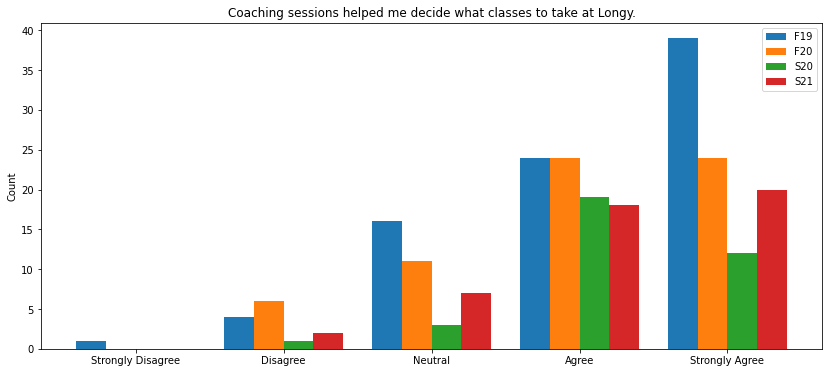

In [20]:
# This can be changed to df or main_df
# Columns can easy be changed too
col = cat_cols['agree'][3]
plot_bar(df,col)

By changing things arounf ,someone can gain intuition and lood deeper. For example,there seems to be improvement in `Support for personal growth` over the semesters. Also, there are no `Strongly Disagree` in 2020 and 2021,this might be because `Strongly Disagree` was not included in the survey at those period.

## Coaching foundation
Different questions were asked each day and would need to be left seperately. The visualization is done pie chart

In [23]:
day = pd.read_excel(data_dir /'DAY 1_ Coaching Foundations Course(1-247).xlsx')

In [25]:
columns=day.columns
columns

Index(['ID', 'Start time', 'Completion time', 'Email', 'Name',
       'What is your email address?',
       'Who were your coaching staff facilitators?',
       'The partnership agreement created today, makes me feel safe to explore and be vulnerable with this group of people.',
       'The fulfillment wheel activity provided an insightful view into where I am right now in terms of fulfillment and life satisfaction.'],
      dtype='object')

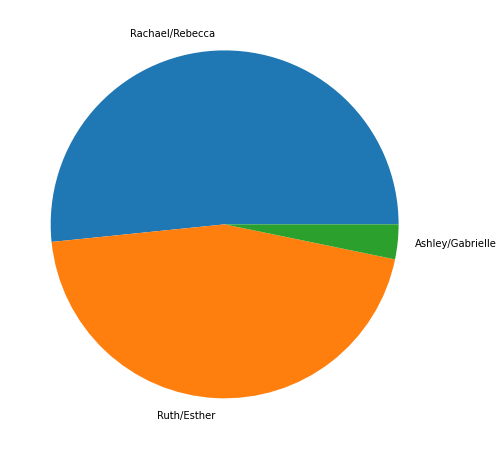

In [27]:
col= 'Who were your coaching staff facilitators?'
counts= day[col].value_counts()
plt.figure(figsize=(8,8))
plt.pie(counts.values,labels=counts.index)
plt.show()

# Summary
I've found a way to combine the days, and that's the purpose of this notebook. I won't be doing more analysis until I get more time and/or dataset. Time was well utilized in cleaning, wrangling, and merging the datasets, as I had to go through each columns to find pattern and anomalities. This stage is very important to perform good analysis, and also takes time.

I hope you noticed in the last notebook that you could edit it easily to visualize any column in line `col = ...` before plots, and not just the 2 I plot. If not, I could make changes to the note and plot as many columns as possible.

The process for merging the days together goes thus:
* Insert Semester
* Merge `What is your email address?` with `Email`. Almost all the `Email` are `.longy.edu` and `anonymous`. The anonymous provide their mail in `What is your email address?`
* Drop row duplicates on Email, Name, and Semester. I don't understand how they happened. e.g **`day1[day1['Email']=='Chengxuan.Li@longy.edu']` where Li Chengxuan filled 40 times on 2020-08-25. Maybe, you should look into why.**
* drop Start time, Completion time, ID.
* Rename each column by prepending day:
* Merge the data

I hope this shows that we're capable to handle your project. This is just the tip of the iceberg, but getting value from the data would take time. Thanks.

## Task to do include 
* Verify email and name and make sure it's clean. E.g `vanessa.moya@longy.edu (I think?)` should be corrected.
* Analyse it together with impact assessment
* Apply NLP on some columns
* and lot more which would be revealed as more analysis is done

In [28]:
# Load data
day1 = pd.read_excel(data_dir / 'DAY 1_ Coaching Foundations Course(1-247).xlsx')
day2 = pd.read_excel(data_dir / 'Day 2_ Coaching Foundations Course(1-232) (1).xlsx')
day3 = pd.read_excel(data_dir / 'Day 3_ Coaching Foundations Course(1-213).xlsx')
day4 = pd.read_excel(data_dir / 'Day 3_ Coaching Foundations Course(1-213).xlsx')
day5 = pd.read_excel(data_dir / 'Day 5_ Coaching Foundations Course(1-228).xlsx')
days = [day1, day2, day3, day4, day5]

In [29]:
# Add column Semester
def add_semester(timestamp, raise_error=True):
    year = timestamp.year
    month = timestamp.month
    if year==2019 and month==9:
        return 'F19'
    elif year==2020 and month==1:
        return 'S20'
    elif year==2020 and month in (8,9):
        return 'F20'
    elif year==2021 and month in (1,2):
        return 'S21'
    elif year==2021 and month==6:
        return 'F21'
    elif raise_error:
        raise ValueError(f"{time} is unknown.")
        
for d in days:
    d.insert(5, 'Semester', d['Start time'].apply(add_semester))

In [30]:
# Merge `What is your email address?` with `Email`
for d in days:
    d['Email'].where(d['Email']!='anonymous', d['What is your email address?'], inplace=True)

In [31]:
# Drop row duplicates
for d in days:
    d.drop_duplicates(['Email', 'Name', 'Semester'], inplace=True)

In [32]:
# Drop columns
for d in days:
    d.drop(['ID', 'Start time', 'Completion time', 'What is your email address?'], axis=1, inplace=True)

In [33]:
# Rename some columns to identify day
for i,d in enumerate(days):
    col_map = {x: f"{i+1}: {x}" for x in d.columns if x not in ['Email', 'Name', 'Semester']}
    d.rename(columns=col_map, inplace=True)

In [34]:
# Combine the data
df = days[0].copy()
for d in days[1:]:
    df = df.merge(d, on=['Email', 'Name', 'Semester'], how='outer')

In [35]:
print(f'Rows: {df.shape[0]}; Columns: {df.shape[1]}')
df.head()

Rows: 322; Columns: 15


,Email,Name,Semester,1: Who were your coaching staff facilitators?,"1: The partnership agreement created today, makes me feel safe to explore and be vulnerable with this group of people.",1: The fulfillment wheel activity provided an insightful view into where I am right now in terms of fulfillment and life satisfaction.,2: How important is it to you that your life's work is in harmony with your personal values?,2: How helpful was the fulfillment wheel and order of importance activity in clarifying things that are most important to you right now?,3: How helpful was the word association activity in helping you identify your lens on different topics and seeing how you might shift your lens?,"3: How helpful was the inner team car activity in discovering different aspects of your self, how you show up in the world, and the possibility of personal choices?",4: How helpful was the word association activity in helping you identify your lens on different topics and seeing how you might shift your lens?,"4: How helpful was the inner team car activity in discovering different aspects of your self, how you show up in the world, and the possibility of personal choices?",5: How likely are you to think about your Champion in your day to day life?,5: How helpful were the Gremlin and Champion activities?,5: What was the most impactful activity in the Coaching Foundations Course for you?
0,Takaaki.Matsumoto@longy.edu,Matsumoto Takaaki,F19,NaN,Agree;,Agree,Extremely important,NaN,NaN,NaN,NaN,NaN,Very likely,Very helpful,NaN
1,Monica.Rajan@longy.edu,Monica Rajan,F19,NaN,Agree;,Agree,Extremely important,NaN,Very helpful,Very helpful,Very helpful,Very helpful,Very likely,Very helpful,NaN
2,Katie.Pyne@longy.edu,Katelyn (Katie) Pyne,F19,NaN,Agree;,Agree,Extremely important,NaN,Very helpful,Very helpful,Very helpful,Very helpful,NaN,NaN,NaN
3,Michael.Clark@longy.edu,Paul Michael (Michael) Clark,F19,NaN,Agree;,Agree,Extremely important,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tim.Flores@longy.edu,Timothy (Tim) Flores,F19,NaN,Agree;,Neutral,Extremely important,NaN,Very helpful,Very helpful,Very helpful,Very helpful,NaN,NaN,NaN
